# Prererequisites

## Load packages and set up the environment

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
import random
from scipy.stats import pearsonr
import scanpy.external as sce

## Loading the dataset

In [2]:
adata_facs = sc.read_h5ad("/Users/aumchampaneri/Databases/tabula-muris-senis-facs-processed-official-annotations-Kidney.h5ad")
adata_drop = sc.read_h5ad("/Users/aumchampaneri/Databases/tabula-muris-senis-droplet-processed-official-annotations-Kidney.h5ad")

/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connect

### Check structure of the data

In [3]:
adata_facs

AnnData object with n_obs × n_vars = 1833 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
adata_drop

AnnData object with n_obs × n_vars = 21647 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Merge the two datasets

In [5]:
adata = adata_facs.concatenate(adata_drop,
                               batch_key='method',
                               batch_categories=['FACS', 'Droplet'],
                               join='outer' # 'outer' to keep all genes
                               )

adata

/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_86339/1416867206.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_facs.concatenate(adata_drop,


AnnData object with n_obs × n_vars = 23480 × 22988
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'tissue_free_annotation'
    var: 'n_cells-Droplet', 'means-Droplet', 'dispersions-Droplet', 'dispersions_norm-Droplet', 'highly_variable-Droplet', 'n_cells-FACS', 'means-FACS', 'dispersions-FACS', 'dispersions_norm-FACS', 'highly_variable-FACS'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

# Preprocess Data and Quality Control

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


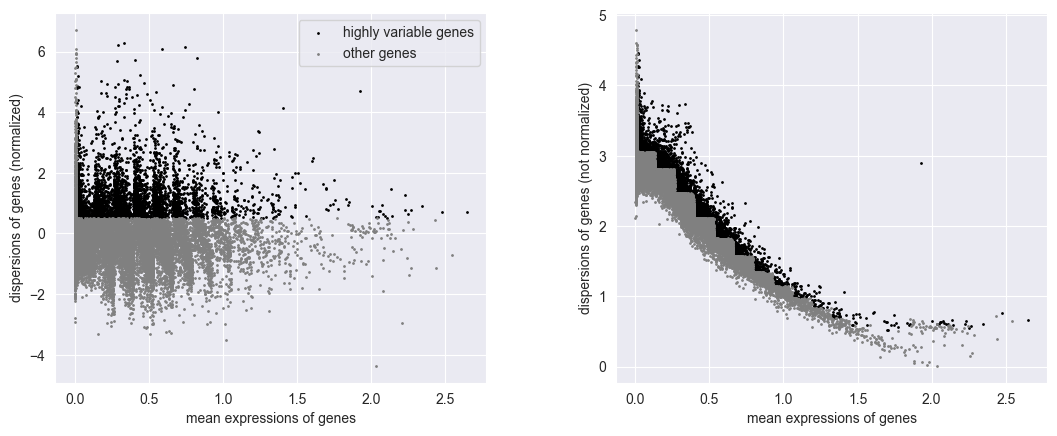

In [6]:
# Basic filtering

# Filter out cells that express fewer than 500 genes to remove low-quality cells, empty droplets, and debris.
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
# Filter out genes that are detected in fewer than 3 cells to eliminate technical noise and very rarely expressed genes.
sc.pp.filter_genes(adata, min_cells=3, inplace=True)

# Normalize, log-transform, and scale the data

# Normalize the total gene expression in each cell to a target sum of 10,000 to correct for differences in sequencing depth.
sc.pp.normalize_total(adata, target_sum=1e4)
# Apply a natural logarithm transformation to the normalized data to stabilize variance and make expression values more comparable.
sc.pp.log1p(adata)

# Identify and plot highly-variable genes

# Identify highly-variable genes based on their mean expression and dispersion.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Generate PCA and UMAP embeddings + Dendrogram Keys

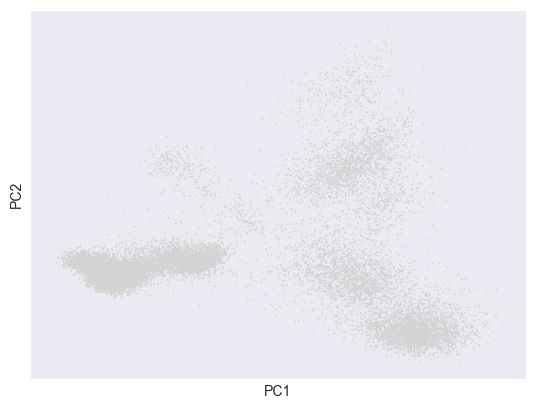

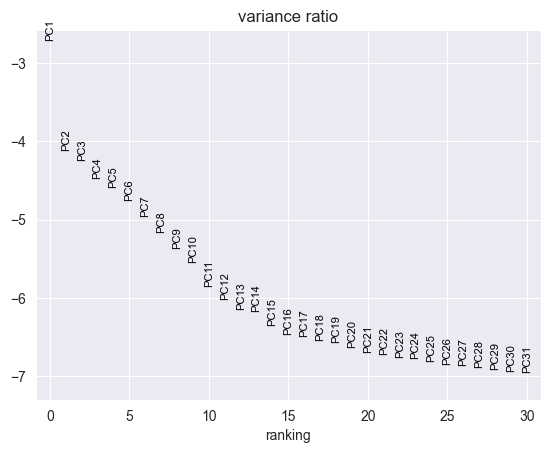

2025-03-28 22:24:37,502 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-28 22:24:42,294 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-28 22:24:42,438 - harmonypy - INFO - Iteration 1 of 10
2025-03-28 22:24:47,967 - harmonypy - INFO - Iteration 2 of 10
2025-03-28 22:24:52,985 - harmonypy - INFO - Iteration 3 of 10
2025-03-28 22:24:57,378 - harmonypy - INFO - Iteration 4 of 10
2025-03-28 22:25:01,620 - harmonypy - INFO - Iteration 5 of 10
2025-03-28 22:25:05,495 - harmonypy - INFO - Iteration 6 of 10
2025-03-28 22:25:09,718 - harmonypy - INFO - Iteration 7 of 10
2025-03-28 22:25:13,796 - harmonypy - INFO - Iteration 8 of 10
2025-03-28 22:25:16,786 - harmonypy - INFO - Iteration 9 of 10
2025-03-28 22:25:19,371 - harmonypy - INFO - Converged after 9 iterations


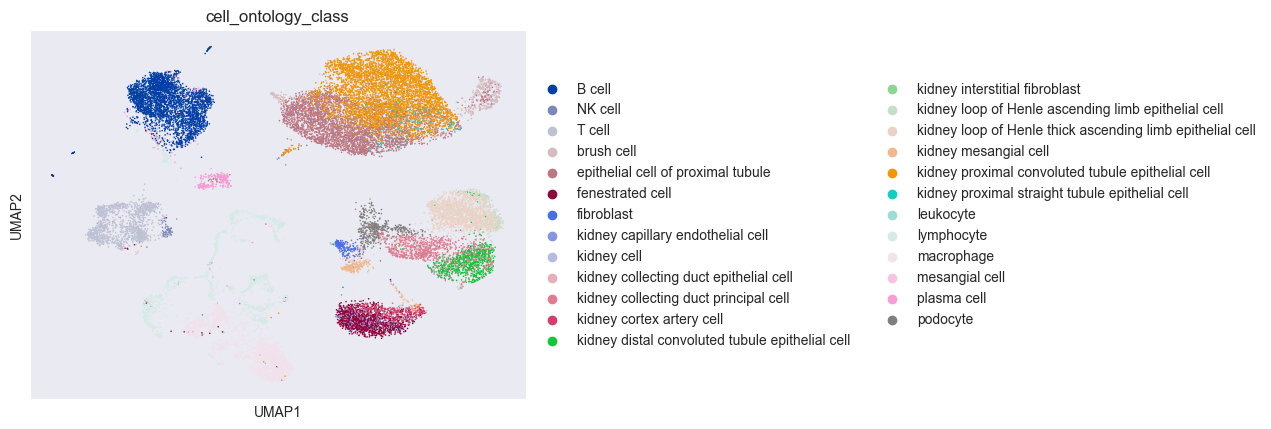

In [14]:
# Principal Component Analysis (PCA)
sc.pp.pca(adata, svd_solver="arpack")
# Plot the PCA -- Uncomment to see the plot
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

# Generate UMAP
sce.pp.harmony_integrate(adata, "method")
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_ontology_class']) # Looks better with dark background

# Calculate leiden clusters
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

# Dendrogram Key for downstream visualization
sc.tl.dendrogram(adata, groupby='cell_ontology_class')

# Dictionaries

## Gene Dictionaries

In [46]:
# All Complement Genes
gene_ensembl = sc.queries.biomart_annotations("mmusculus",
                                              ["ensembl_gene_id", "external_gene_name"],
                                              host='www.ensembl.org'
                                              )

mouse_gene_names = [
    'C1d', 'C1qa', 'C1qb', 'C1qc', 'C1qbp', 'C1r', 'C1rl', 'C1s', 'C2', 'C3', 'C3ar1', 'C4a',
    'C4b', 'C4bp', 'C4bpb', 'Hc', 'C5ar1', 'C5ar2', 'C6', 'C7', 'C8a', 'C8b', 'C8g', 'C9',
    'Calr', 'Cd46', 'Cd55', 'Cd59a', 'Cd93', 'Cfb', 'Cfd', 'Cfh', 'Cfhr1', 'Cfhr2', 'Cfhr3',
    'Cfhr4', 'Cfhr5', 'Cfi', 'Clu', 'Colec10', 'Colec11', 'Cpb2', 'Cpn1', 'Cpn2', 'Csmd1',
    'Cfp', 'Cr1', 'Cr2', 'Fcn1', 'Fcn2', 'Fcn3', 'Itgam', 'Itgamx', 'Itgax', 'Itgb2', 'Masp1',
    'Masp2', 'Masp3', 'Mbl2', 'Serping1', 'Susd4', 'Vsig4', 'Vcp'
]

# Find the mouse_gene_names in the gene_ensembl DataFrame
mouse_gene_names = set(mouse_gene_names)
gene_ensembl_names = set(gene_ensembl["external_gene_name"].values)

# Find the intersection
intersection = mouse_gene_names.intersection(gene_ensembl_names)

# Filter the gene_ensembl DataFrame to include only the intersecting genes
filtered_gene_ensembl = gene_ensembl[gene_ensembl["external_gene_name"].isin(intersection)]

# Alphabetize the DataFrame by external_gene_name
filtered_gene_ensembl = filtered_gene_ensembl.sort_values(by="external_gene_name")

# Reset the index
filtered_gene_ensembl = filtered_gene_ensembl.reset_index(drop=True)

# Create a dictionary with gene names on the left and Ensembl codes on the right
gene_dict = dict(zip(filtered_gene_ensembl["external_gene_name"], filtered_gene_ensembl["ensembl_gene_id"]))

# Print the dictionary
print(gene_dict)

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

print("gene_names =", gene_dict_names)
print("gene_keys =", gene_dict_keys)

# Create filter gene object
def filter_genes(gene_dict_names, genes_to_remove):
    # Filter out genes that are in the genes_to_remove list
    filtered_genes = [gene for gene in gene_dict_names if gene not in genes_to_remove]
    return filtered_genes

# Example list of genes to remove
genes_to_remove = ['C1QA', 'C1QB', 'C1QC', 'C1QBP']

# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict, genes_to_remove)
print(filtered_gene_list)


{'C1d': 'ENSMUSG00000000581', 'C1qa': 'ENSMUSG00000036887', 'C1qb': 'ENSMUSG00000036905', 'C1qbp': 'ENSMUSG00000018446', 'C1qc': 'ENSMUSG00000036896', 'C1rl': 'ENSMUSG00000038527', 'C2': 'ENSMUSG00000024371', 'C3': 'ENSMUSG00000024164', 'C3ar1': 'ENSMUSG00000040552', 'C4a': 'ENSMUSG00000015451', 'C4b': 'ENSMUSG00000073418', 'C4bp': 'ENSMUSG00000026405', 'C5ar1': 'ENSMUSG00000049130', 'C5ar2': 'ENSMUSG00000074361', 'C6': 'ENSMUSG00000022181', 'C7': 'ENSMUSG00000079105', 'C8a': 'ENSMUSG00000035031', 'C8b': 'ENSMUSG00000029656', 'C8g': 'ENSMUSG00000015083', 'C9': 'ENSMUSG00000022149', 'Calr': 'ENSMUSG00000003814', 'Cd46': 'ENSMUSG00000016493', 'Cd55': 'ENSMUSG00000026399', 'Cd59a': 'ENSMUSG00000032679', 'Cd93': 'ENSMUSG00000027435', 'Cfb': 'ENSMUSG00000090231', 'Cfd': 'ENSMUSG00000061780', 'Cfh': 'ENSMUSG00000026365', 'Cfhr1': 'ENSMUSG00000057037', 'Cfhr2': 'ENSMUSG00000033898', 'Cfhr3': 'ENSMUSG00000090623', 'Cfhr4': 'ENSMUSG00000070594', 'Cfi': 'ENSMUSG00000058952', 'Cfp': 'ENSMUSG00000

## Cell Type Dictionaries

In [45]:
# List all the cell types in the dataset
cell_types = adata.obs['cell_ontology_class'].unique()
print("Cell Types:")
for cell_ontology_class in cell_types:
    print(f"  {cell_ontology_class}")

# Define the groups for cell types
cell_type_groups = {
    'Myeloid Cells': [
        'macrophage'
    ],
    'Kidney Cells': [
        'podocyte',
        'mesangial cell',
        'kidney mesangial cell',
        'kidney cell'
    ],
    'Endothelial Cells': [
        'kidney capillary endothelial cell'
    ],
    'Fibroblasts': [
        'fibroblast',
        'kidney interstitial fibroblast'
    ],
    'Epithelial Cells': [
        'epithelial cell of proximal tubule',
        'kidney collecting duct epithelial cell',
        'kidney loop of Henle ascending limb epithelial cell',
        'kidney collecting duct principal cell',
        'kidney proximal convoluted tubule epithelial cell',
        'kidney loop of Henle thick ascending limb epithelial cell',
        'kidney distal convoluted tubule epithelial cell',
        'kidney proximal straight tubule epithelial cell',
        'brush cell'
    ],
    'Immune Cells': [
        'T cell',
        'B cell',
        'lymphocyte',
        'NK cell',
        'plasma cell',
        'leukocyte'
    ],
    # 'Smooth Muscle Cells': [
    #     # No smooth muscle cells provided in the input list.
    # ],
    'Unknown': [
        'fenestrated cell',
        'kidney cortex artery cell'
    ]
}



# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_groups.items():
    adata.obs.loc[adata.obs['cell_ontology_class'].isin(cell_types), 'cell_type_group'] = group

# Check the new amount of cell types
cell_type_groups = adata.obs['cell_type_group'].unique()
print("Cell Type Groups:")
for group in cell_type_groups:
    print(f"  {group}")

Cell Types:
  epithelial cell of proximal tubule
  kidney collecting duct epithelial cell
  kidney loop of Henle ascending limb epithelial cell
  macrophage
  T cell
  fenestrated cell
  kidney collecting duct principal cell
  B cell
  mesangial cell
  kidney interstitial fibroblast
  kidney proximal convoluted tubule epithelial cell
  kidney mesangial cell
  kidney loop of Henle thick ascending limb epithelial cell
  kidney distal convoluted tubule epithelial cell
  lymphocyte
  brush cell
  podocyte
  kidney cortex artery cell
  NK cell
  kidney capillary endothelial cell
  fibroblast
  plasma cell
  kidney proximal straight tubule epithelial cell
  leukocyte
  kidney cell
Cell Type Groups:
  Epithelial Cells
  Myeloid Cells
  Immune Cells
  Unknown
  Kidney Cells
  Fibroblasts
  Endothelial Cells


# Plotting the Data

## UMAP Plots

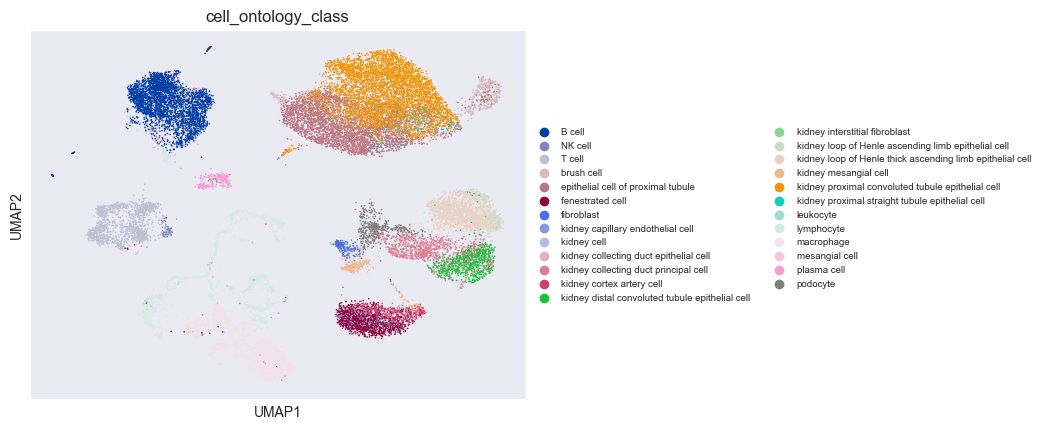

In [23]:
sc.pl.umap(adata,
           color=['cell_ontology_class'],
           legend_fontsize='x-small',
           legend_fontweight='light',
           # palette='custom_palette',
           # save='_cell-type_NKD.pdf',
           neighbors_key='harmony'
           )

In [3]:
sc.pl.umap(adata,
           color=['cell_type_group'],
           legend_fontsize='x-small',
           legend_fontweight='light',
           # palette='tab10',
           # save='_cell-type-group_NKD.pdf'
           neighbors_key='harmony'
           )

NameError: name 'sc' is not defined

## C3 and  CFH UMAP

/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_86339/3151842389.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


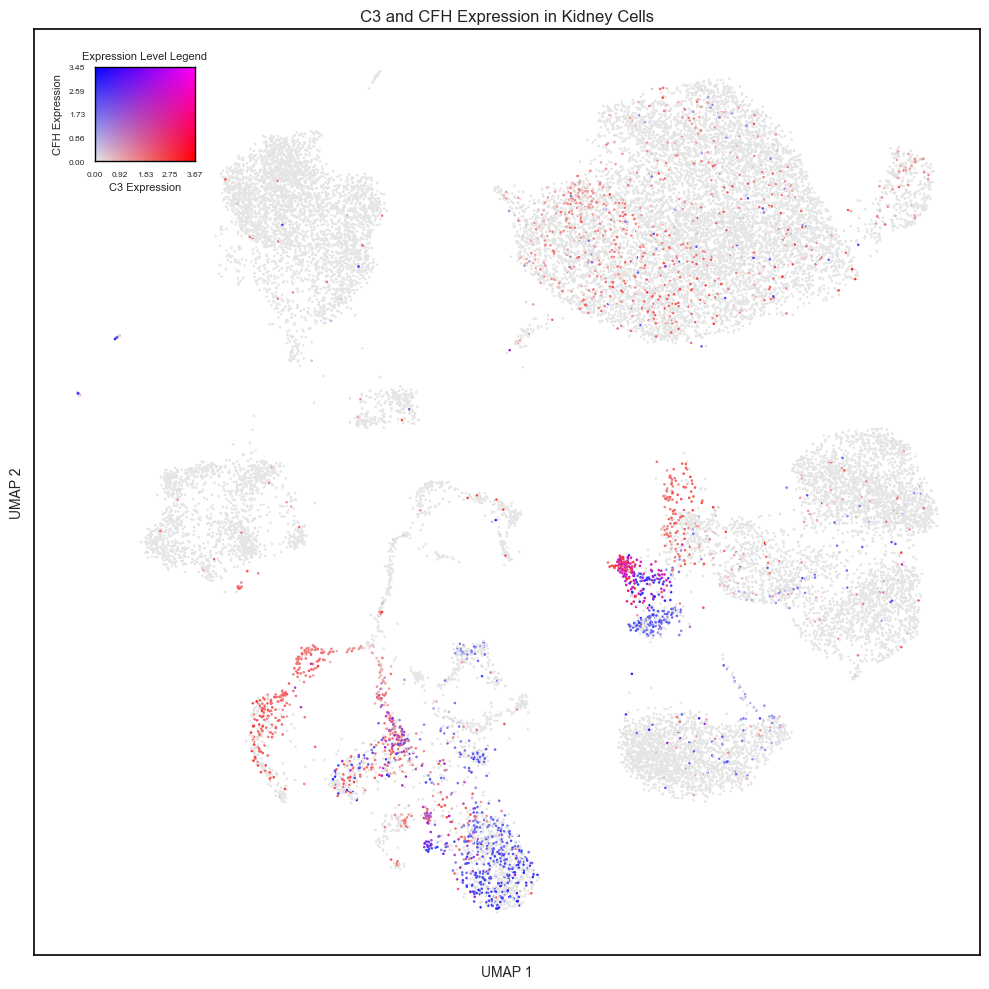

In [31]:
# Define gene keys for C3 and CFH
c3_key = "C3"  # C3
cfh_key = "Cfh"  # CFH


def get_expression(key):
    exp = adata[:, key].X
    return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()

# Extract expression data
c3_vals = get_expression(c3_key)
cfh_vals = get_expression(cfh_key)

# Determine the data range for each gene
c3_min, c3_max = c3_vals.min(), c3_vals.max()
cfh_min, cfh_max = cfh_vals.min(), cfh_vals.max()

# Generate five evenly spaced tick values
c3_ticks = np.linspace(c3_min, c3_max, 5)
cfh_ticks = np.linspace(cfh_min, cfh_max, 5)

# Rescale the raw data to [0,1] for color mapping
X_scatter = (c3_vals - c3_min) / (c3_max - c3_min)
Y_scatter = (cfh_vals - cfh_min) / (cfh_max - cfh_min)

# Define the white basis as light grey
white_val = 0.9

# Compute weight factors
w = (1 - X_scatter) * (1 - Y_scatter)
r = X_scatter * (1 - Y_scatter)
b = (1 - X_scatter) * Y_scatter
p = X_scatter * Y_scatter

# Compute scatter plot colors
scatter_R = white_val * w + 1 * r + 0 * b + 1 * p
scatter_G = white_val * w + 0 * r + 0 * b + 0 * p
scatter_B = white_val * w + 0 * r + 1 * b + 1 * p

scatter_colors = np.column_stack([scatter_R, scatter_G, scatter_B])
scatter_colors = np.clip(scatter_colors, 0, 1)

# Create figure and axes
fig = plt.figure(figsize=(10, 10), facecolor='white')
ax_umap = fig.add_subplot(111)
ax_legend = fig.add_axes([0.10, 0.83, 0.10, 0.10])
ax_umap.set_facecolor('white')

# Plot UMAP scatter
ax_umap.scatter(
    adata.obsm['X_umap'][:, 0],
    adata.obsm['X_umap'][:, 1],
    c=scatter_colors,
    s=0.75,
    alpha=1.0
)

ax_umap.set_title('C3 and CFH Expression in Kidney Cells')
ax_umap.set_xlabel('UMAP 1')
ax_umap.set_ylabel('UMAP 2')
ax_umap.grid(False)
ax_umap.tick_params(axis='both', which='both', length=0)
ax_umap.set_xticklabels([])
ax_umap.set_yticklabels([])

for spine in ax_umap.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.2)

# ---- Build the legend colormap ----
n_bins = 100
x_lin = np.linspace(c3_min, c3_max, n_bins)
y_lin = np.linspace(cfh_min, cfh_max, n_bins)
X_leg, Y_leg = np.meshgrid(x_lin, y_lin)

# Rescale legend meshgrid values to [0,1]
X_leg_scaled = (X_leg - c3_min) / (c3_max - c3_min)
Y_leg_scaled = (Y_leg - cfh_min) / (cfh_max - cfh_min)

# Compute weight factors for the legend
w_leg = (1 - X_leg_scaled) * (1 - Y_leg_scaled)
r_leg = X_leg_scaled * (1 - Y_leg_scaled)
b_leg = (1 - X_leg_scaled) * Y_leg_scaled
p_leg = X_leg_scaled * Y_leg_scaled

# Compute legend color mapping
legend_R = white_val * w_leg + 1 * r_leg + 0 * b_leg + 1 * p_leg
legend_G = white_val * w_leg + 0 * r_leg + 0 * b_leg + 0 * p_leg
legend_B = white_val * w_leg + 0 * r_leg + 1 * b_leg + 1 * p_leg

legend_color = np.stack([legend_R, legend_G, legend_B], axis=2)
legend_color = np.clip(legend_color, 0, 1)

ax_legend.imshow(legend_color, origin='lower', extent=[c3_min, c3_max, cfh_min, cfh_max])
ax_legend.set_xlabel('C3 Expression', fontsize=8)
ax_legend.set_ylabel('CFH Expression', fontsize=8)
ax_legend.set_title('Expression Level Legend', fontsize=8)
ax_legend.grid(False)

# Apply the new tick values
ax_legend.set_xticks(c3_ticks)
ax_legend.set_yticks(cfh_ticks)
ax_legend.set_xticklabels([f"{val:.2f}" for val in c3_ticks], fontsize=6)
ax_legend.set_yticklabels([f"{val:.2f}" for val in cfh_ticks], fontsize=6)

for spine in ax_legend.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tight_layout()
# plt.savefig('umap_C3vCFH_NKD.pdf')
plt.show()

## Scatter Plots

Category counts:
category
Neither       20493
C3 only        1598
CFH only        855
C3 and CFH      327
Name: count, dtype: int64
Pearson correlation (C3 vs CFH): R=0.155, p=1.501e-124


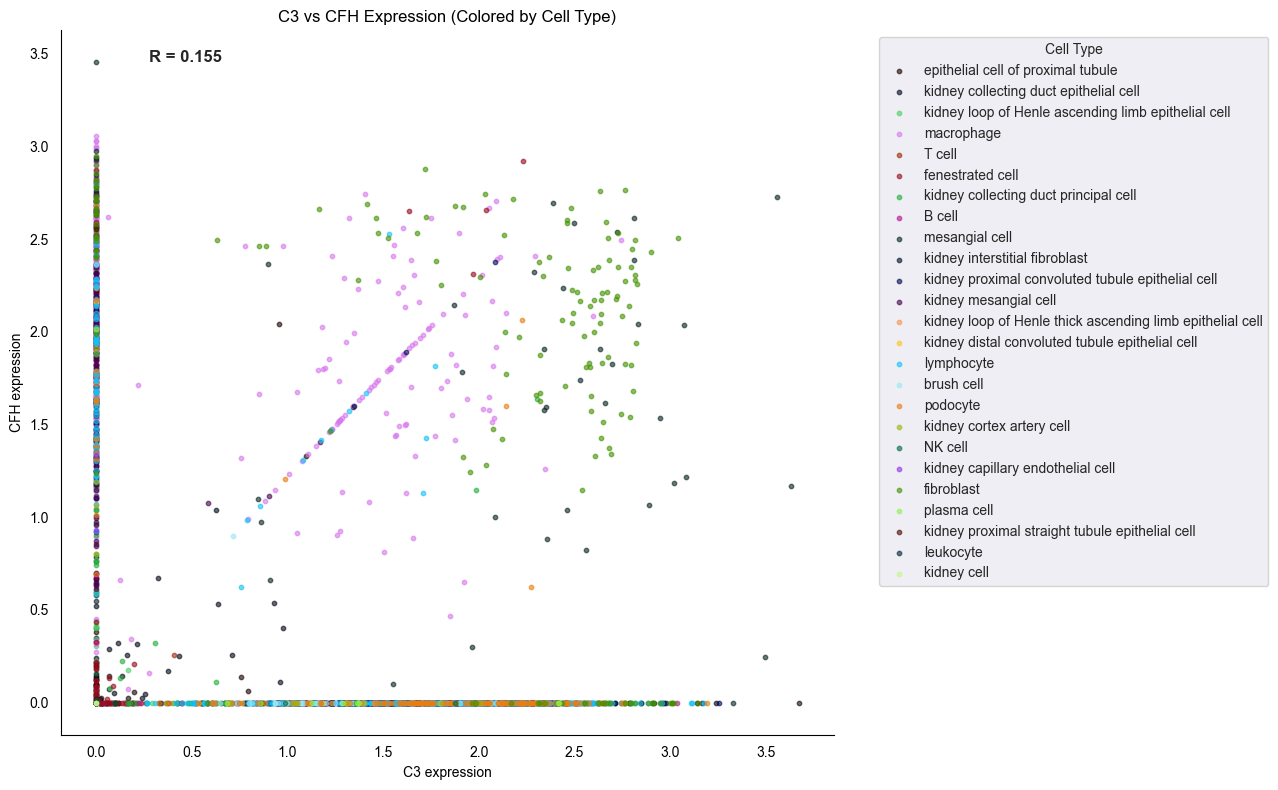

In [37]:
# Function to extract expression data
def get_expression(key):
    """
    Extracts expression data for a given gene key.

    Parameters:
    key (str): Gene key to extract expression data for.

    Returns:
    np.ndarray: Flattened array of expression data.
    """
    exp = adata[:, key].X
    return exp.toarray().flatten() if scipy.sparse.issparse(exp) else exp.flatten()

# Get the ENSEMBL IDs for C3 and CFH from the gene dictionary
c3_id = "C3" # "ENSG00000125730"
cfh_id = "Cfh"               # "ENSG00000000971"

# Extract expression data for C3 and CFH
c3_expr = get_expression(c3_id)
cfh_expr = get_expression(cfh_id)

# Create DataFrame with expression values and cell type data
df = pd.DataFrame({
    "C3": c3_expr,
    "CFH": cfh_expr,
    "cell_ontology_class": adata.obs["cell_ontology_class"].values,
    "cell_type_group": adata.obs["cell_type_group"].values
})

# Define categories based on expression > 0
conditions = [
    (df["C3"] > 0) & (df["CFH"] > 0),
    (df["C3"] > 0) & (df["CFH"] == 0),
    (df["C3"] == 0) & (df["CFH"] > 0),
    (df["C3"] == 0) & (df["CFH"] == 0),
]
choices = ["C3 and CFH", "C3 only", "CFH only", "Neither"]
df["category"] = np.select(conditions, choices, default="Other")

# Print category counts
print("Category counts:")
print(df["category"].value_counts())

# Compute Pearson correlation
r, p_value = pearsonr(df["C3"], df["CFH"])
print(f"Pearson correlation (C3 vs CFH): R={r:.3f}, p={p_value:.3e}")

###############################################################################
# Scatter plot: Color points by cell type with improved aesthetics
###############################################################################

# Define unique cell types and their colors
cell_types = df["cell_ontology_class"].unique()
# palette = sns.color_palette("husl", n_colors=len(cell_types))
custom_palette = [
    "#020918", "#424e66", "#ffc61a", "#a2b20a", "#459201",
    "#4d0a00", "#9d2c07", "#ea7d10", "#f8be49", "#c3f787", "#47d163", "#107a68", "#01253c",
    "#082525", "#03683e", "#21b039", "#8df34f", "#99e7f4", "#12c2f8", "#0341b5", "#020a55",
    "#030d30", "#0b6f9d", "#22e2d5", "#d878ed", "#9232ec", "#30008f", "#160132", "#46024b",
    "#830165", "#b9138d", "#e057c9", "#faa3ab", "#ef5d7f", "#ee113d", "#980b1c", "#3f0409",
    "#190400", "#ba5017", "#f4964e", "#fecc81"
]
random.shuffle(custom_palette)
palette = sns.color_palette(custom_palette, n_colors=len(cell_types))
cell_type_colors = dict(zip(cell_types, palette))

# Create scatter plot
fig, ax = plt.subplots(figsize=(13, 8))

# Plot each cell type with its corresponding color
[
    ax.scatter(
        df[df["cell_ontology_class"] == cell_type]["C3"],
        df[df["cell_ontology_class"] == cell_type]["CFH"],
        s=10,
        alpha=0.6,
        color=cell_type_colors[cell_type],
        label=cell_type
    )
    for cell_type in cell_types
]

# Add Pearson correlation coefficient (R) at the top of the plot
ax.text(
    df["C3"].max() * 0.075,  # X position
    df["CFH"].max() * 1.00,  # Y position
    f"R = {r:.3f}",
    fontsize=12,
    fontweight="bold"
)

# Set axis properties
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", colors="black", direction="out", length=5, width=1.5)
ax.tick_params(axis="y", colors="black", direction="out", length=5, width=1.5)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
ax.grid(False)

# Labels and title
ax.set_xlabel("C3 expression", color="black")
ax.set_ylabel("CFH expression", color="black")
ax.set_title("C3 vs CFH Expression (Colored by Cell Type)", color="black")

# Move legend outside the plot to the right
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True, fontsize=10)

plt.tight_layout()
# plt.savefig('scatterplot_C3vCFH-cell-type_NKD.pdf')
plt.show()

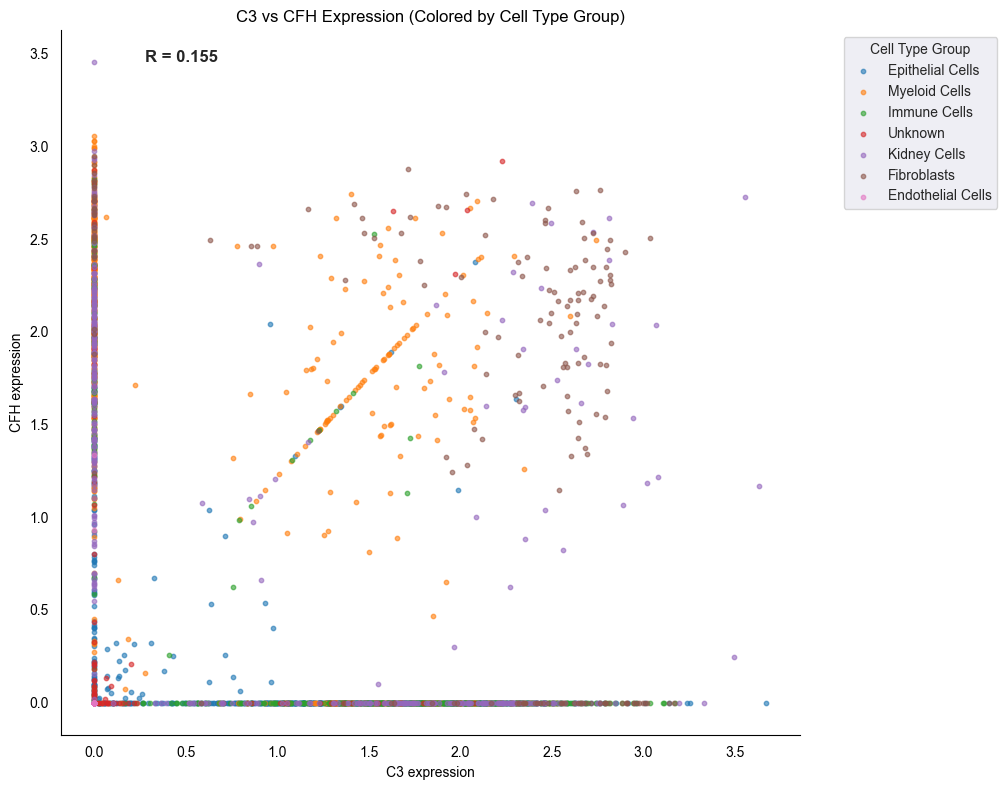

In [38]:
# Define unique cell type groups and their colors
cell_type_groups = df["cell_type_group"].unique()
palette = sns.color_palette("tab10", n_colors=len(cell_type_groups))
cell_type_group_colors = dict(zip(cell_type_groups, palette))

# Create scatter plot
fig, ax = plt.subplots(figsize=(10.2, 8))

# Plot each cell type group with its corresponding color
for cell_type_group in cell_type_groups:
    subset = df[df["cell_type_group"] == cell_type_group]
    ax.scatter(
        subset["C3"],
        subset["CFH"],
        s=10,
        alpha=0.6,
        color=cell_type_group_colors[cell_type_group],
        label=cell_type_group
    )

# Add Pearson correlation coefficient (R) at the top of the plot
ax.text(
    df["C3"].max() * 0.075,  # X position
    df["CFH"].max() * 1.00,  # Y position
    f"R = {r:.3f}",
    fontsize=12,
    fontweight="bold"
)

# Set axis properties
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", colors="black", direction="out", length=5, width=1.5)
ax.tick_params(axis="y", colors="black", direction="out", length=5, width=1.5)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
ax.grid(False)

# Labels and title
ax.set_xlabel("C3 expression", color="black")
ax.set_ylabel("CFH expression", color="black")
ax.set_title("C3 vs CFH Expression (Colored by Cell Type Group)", color="black")

# Move legend outside the plot to the right
ax.legend(title="Cell Type Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True, fontsize=10)

plt.tight_layout()
# plt.savefig('scatterplot_C3vCFH-cell-group_NKD.pdf')
plt.show()

## Matrix Plots

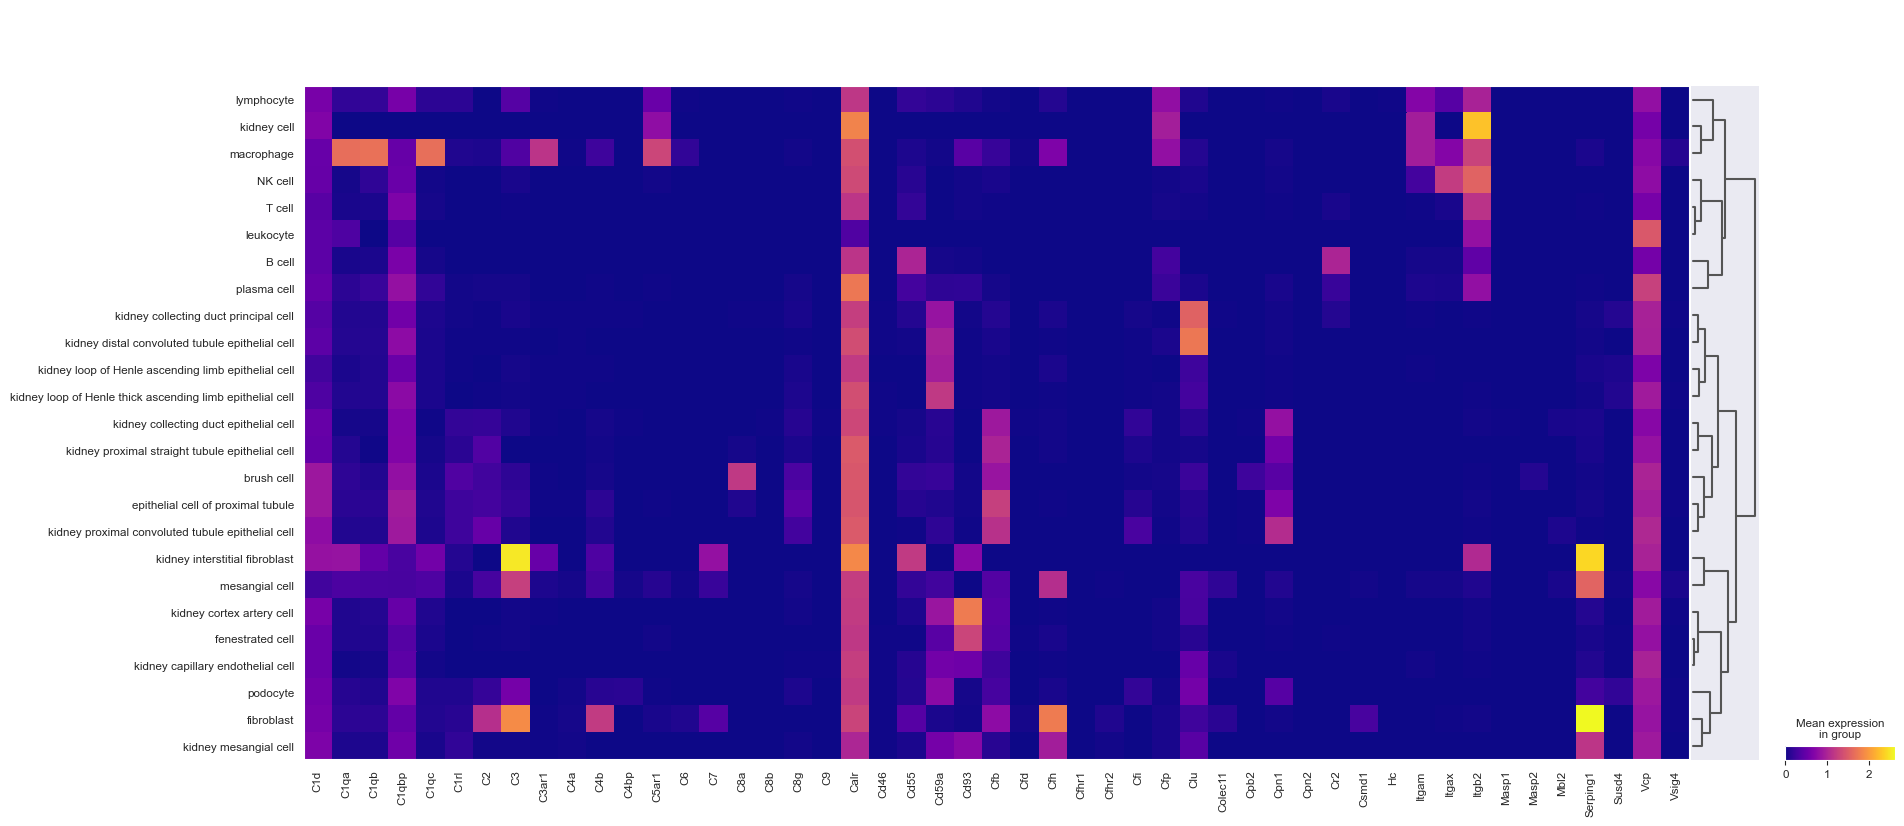

In [48]:
# Example list of genes to remove
genes_to_remove = ['C5ar2', 'Cfhr3', 'Cfhr4', 'Colec10']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement genes as a matrix plot
sc.pl.MatrixPlot(adata,
                 filtered_gene_list,
                 groupby='cell_ontology_class',
                 # gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Complement Genes Expression in Kidney Cells',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()
# .savefig('matrixplot_aG-aC_NKD.pdf')

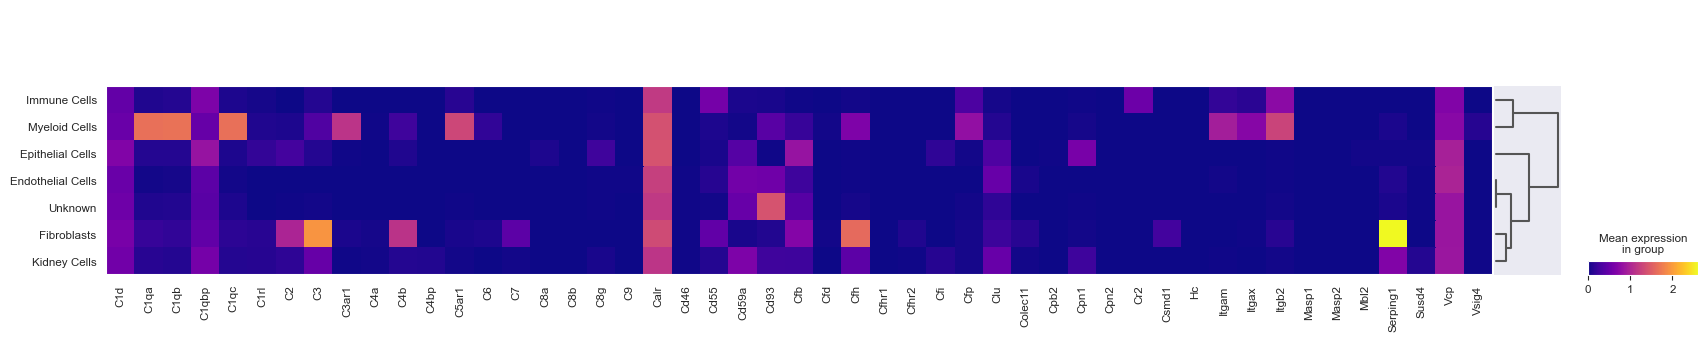

In [50]:
# Example list of genes to remove
genes_to_remove = ['C5ar2', 'Cfhr3', 'Cfhr4', 'Colec10']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement genes as a matrix plot only for cell_type_groups
sc.pl.MatrixPlot(adata,
                 filtered_gene_list,
                 groupby='cell_type_group',
                 # gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Complement Genes Expression in Kidney Cells',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()
 # .savefig('matrixplot_aG-sC_NKD.pdf')

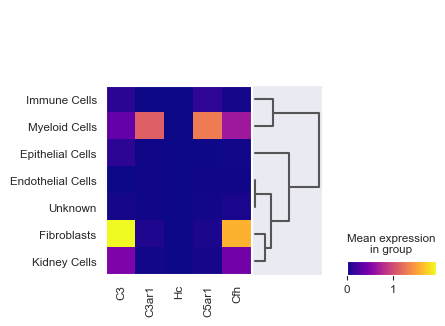

In [57]:
# Define the gene set for plotting
entry_pathway_comp = ['C3', 'C3ar1', 'Hc', 'C5ar1', 'Cfh']

# Plot the expression of complement genes as a matrix plot only for cell_type_groups
sc.pl.MatrixPlot(adata,
                 entry_pathway_comp,
                 groupby='cell_type_group',
                 # gene_symbols='feature_name',
                 use_raw=False,
                 log=False,
                 # title='Classical Pathway Components',
                 ).add_dendrogram(show=True, size=0.9).style(cmap='plasma', edge_color='none').show()
# .savefig('matrixplot_sG-sC_NKD.pdf')

## Dot Plots

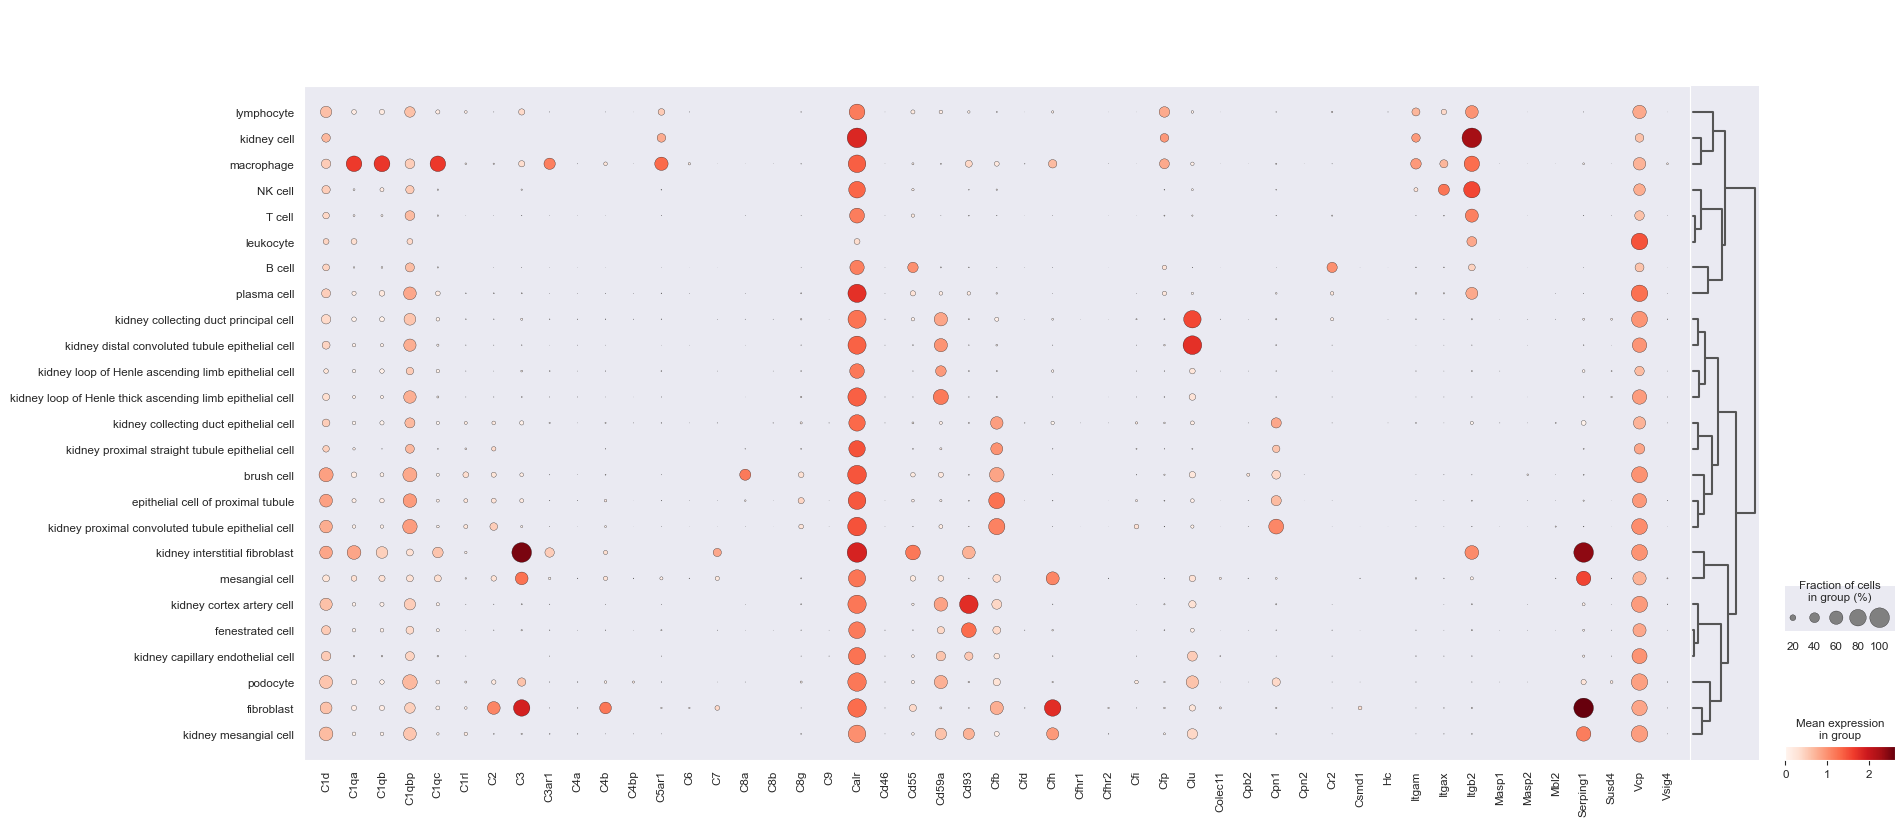

In [59]:
# Example list of genes to remove
genes_to_remove = ['C5ar2', 'Cfhr3', 'Cfhr4', 'Colec10']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(adata,
              filtered_gene_list,
              groupby='cell_ontology_class',
              # gene_symbols='feature_name',
              use_raw=False,
              log=False,
              ).add_dendrogram(show=True,size=0.9).show()
# .savefig('dotplot_aG-aC_NKD.pdf')

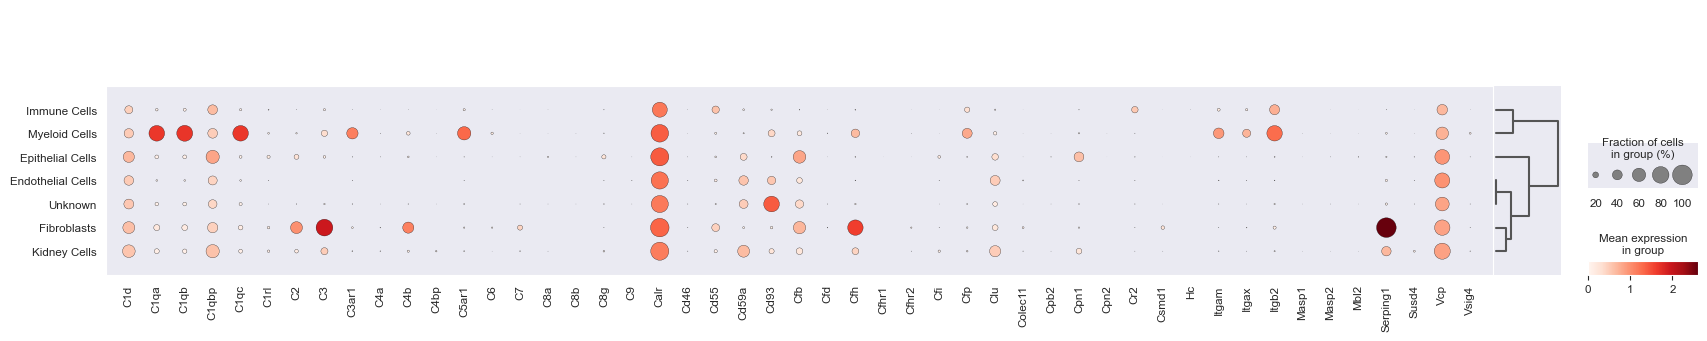

In [60]:
# Example list of genes to remove
genes_to_remove = ['C5ar2', 'Cfhr3', 'Cfhr4', 'Colec10']
# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict_names, genes_to_remove)

# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(adata,
              filtered_gene_list,
              groupby='cell_type_group',
              # gene_symbols='feature_name',
              use_raw=False,
              log=False,
              ).add_dendrogram(show=True,size=0.9).show()
# .savefig('dotplot_aG-sC_NKD.pdf')

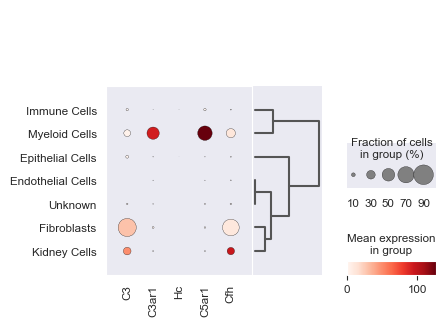

In [63]:
# Define the gene set for plotting
entry_pathway_comp = ['C3', 'C3ar1', 'Hc', 'C5ar1', 'Cfh']

# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(adata,
              entry_pathway_comp,
              groupby='cell_type_group',
              # gene_symbols='feature_name'
              ).add_dendrogram(show=True,size=0.9).show()
# .savefig('dotplot_aG-aC_NKD.pdf')